### Notebook to process benchmar results

Please run this notebook after running all the benchmarks and storing them in the `results` dir. This will export them in the desired format for the single node benchmark plots of [qdrant.tech/benchmarks](https://qdrant.tech/benchmarks)

In [2]:
from pathlib import Path
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timezone

In [3]:
DATA_DIR = Path().resolve().parent / "results"
DATA_DIR, list(DATA_DIR.glob("*.json"))[0].name

(WindowsPath('C:/git/vector-db-benchmark/results'),
 'elasticsearch-m-16-ef-128-europeana-all-search-0-2024-09-27-15-32-36.json')

In [4]:
PATH_REGEX = re.compile(r"(?P<engine_name>("
                        r"?P<engine>[a-z\-]+)"
                        r"\-m\-(?P<m>[0-9]+)"
                        r"\-ef\-(?P<ef>[0-9]+)"
                        r")"
                        r"\-(?P<dataset>[a-zA-Z0-9\-]+)"
                        r"\-(?P<operation>(search)|(upload))"
                        r"(\-(?P<search_index>[0-9]{1,2})\-)?"
                        r"\-?(?P<date>.*)\.json")

In [5]:
upload_results, search_results = [], []

for path in DATA_DIR.glob("*.json"):
    match = PATH_REGEX.match(path.name)
    if match is None:
        continue

    experiment = match.groupdict()

    with open(path, "r") as fp:
        stats = json.load(fp)

    params = stats["params"]
    dataset = params.pop("dataset")
    engine = params.pop("engine")

    entry = {
        "dataset": dataset,
        "engine": engine,
        "m": match["m"],
        "ef": match["ef"],
        "date": match["date"],
        "params": params,
        "results": stats["results"],
    }

    if experiment["operation"] == "search":
        entry.update({"search_index": match["search_index"]})
        search_results.append(entry)
    elif experiment["operation"] == "upload":
        upload_results.append(entry)
    else:
        raise Exception("Unknown operation")

len(upload_results), len(search_results)

(4, 26)

In [6]:
upload_results, search_results[0]

([{'dataset': 'europeana-all',
   'engine': 'elasticsearch',
   'm': '16',
   'ef': '128',
   'date': '2024-09-27-15-32-21',
   'params': {'experiment': 'elasticsearch-m-16-ef-128',
    'parallel': 16,
    'index_options': {'m': 16, 'ef_construction': 128}},
   'results': {'post_upload': {},
    'upload_time': 11927.576406253036,
    'total_time': 96497.39399532299}},
  {'dataset': 'europeana-all',
   'engine': 'milvus',
   'm': '16',
   'ef': '128',
   'date': '2024-09-18-02-03-37',
   'params': {'experiment': 'milvus-m-16-ef-128',
    'parallel': 16,
    'index_params': {'efConstruction': 128, 'M': 16}},
   'results': {'post_upload': {},
    'upload_time': 3037.5825580669334,
    'total_time': 5517.605082381982}},
  {'dataset': 'europeana-all',
   'engine': 'milvus',
   'm': '16',
   'ef': '128',
   'date': '2024-09-18-14-20-32',
   'params': {'experiment': 'milvus-m-16-ef-128',
    'parallel': 16,
    'index_params': {'efConstruction': 128, 'M': 16}},
   'results': {'post_upload': {

In [7]:
upload_df = pd.DataFrame(upload_results)
upload_df["date"] = pd.to_datetime(upload_df["date"], format="%Y-%m-%d-%H-%M-%S")
upload_df = upload_df.sort_values("date", ascending=False) \
    .groupby(["engine", "m", "ef", "dataset"]) \
    .first()

temp_df = upload_df.copy()
temp_df["total_time"] = temp_df["results"].apply(lambda x: x["total_time"])
temp_df.sort_values("total_time", ascending=True).head(n=5)

,,,,date,params,results,total_time
engine,m,ef,dataset,,,,
milvus,16,128,europeana-all,2024-09-18 14:20:32,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'post_upload': {}, 'upload_time': 3182.631347...",5670.570973
qdrant,16,128,europeana-all,2024-09-20 02:29:14,"{'experiment': 'qdrant-m-16-ef-128', 'parallel...","{'post_upload': {}, 'upload_time': 2718.588352...",11420.899321
elasticsearch,16,128,europeana-all,2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'post_upload': {}, 'upload_time': 11927.57640...",96497.393995


In [8]:
search_df = pd.DataFrame(search_results)
search_df["date"] = pd.to_datetime(search_df["date"], format="%Y-%m-%d-%H-%M-%S")
search_df = search_df.sort_values("date", ascending=False) \
    .groupby(["engine", "m", "ef", "dataset", "search_index"]) \
    .first()

temp_df = search_df.copy()
temp_df['rps'] = temp_df['results'].apply(lambda x: x["rps"])
temp_df.sort_values("rps", ascending=False).head(n=10)

date  \
engine        m  ef  dataset       search_index                       
qdrant        16 128 europeana-all 4            2024-09-20 02:29:34   
                                   0            2024-09-20 02:29:15   
                                   5            2024-09-20 02:29:50   
                                   1            2024-09-20 02:29:15   
elasticsearch 16 128 europeana-all 3            2024-09-27 15:33:03   
qdrant        16 128 europeana-all 6            2024-09-20 02:30:06   
                                   2            2024-09-20 02:29:17   
                                   7            2024-09-20 02:30:24   
                                   3            2024-09-20 02:29:19   
elasticsearch 16 128 europeana-all 5            2024-09-27 15:33:38   

                                                                                            params  \
engine        m  ef  dataset       search_index                                                      
qdrant        16 128 europeana-all 4             {'experiment': 'qdrant-m-16-ef-128', 'parallel...   
                                   0             {'experiment': 'qdrant-m-16-ef-128', 'parallel...   
                                   5             {'experiment': 'qdrant-m-16-ef-128', 'parallel...   
                                   1             {'experiment': 'qdrant-m-16-ef-128', 'parallel...   
elasticsearch 16 128 europeana-all 3             {'experiment': 'elasticsearch-m-16-ef-128', 'p...   
qdrant        16 128 europeana-all 6             {'experiment': 'qdrant-m-16-ef-128', 'parallel...   
                                   2             {'experiment': 'qdrant-m-16-ef-128', 'parallel...   
                                   7             {'experiment': 'qdrant-m-16-ef-128', 'parallel...   
                                   3             {'experiment': 'qdrant-m-16-ef-128', 'parallel...   
elasticsearch 16 128 europeana-all 5             {'experiment': 'elasticsearch-m-16-ef-128', 'p...   

                                                                                           results  \
engine        m  ef  dataset       search_index                                                      
qdrant        16 128 europeana-all 4             {'total_time': 0.49271493300329894, 'mean_time...   
                                   0             {'total_time': 0.6115625849924982, 'mean_time'...   
                                   5             {'total_time': 0.6792151329573244, 'mean_time'...   
                                   1             {'total_time': 0.7583689070306718, 'mean_time'...   
elasticsearch 16 128 europeana-all 3             {'total_time': 0.9632914359681308, 'mean_time'...   
qdrant        16 128 europeana-all 6             {'total_time': 1.0996972400462255, 'mean_time'...   
                                   2             {'total_time': 1.184665814973414, 'mean_time':...   
                                   7             {'total_time': 1.8287332069594413, 'mean_time'...   
                                   3             {'total_time': 1.9599559569032863, 'mean_time'...   
elasticsearch 16 128 europeana-all 5             {'total_time': 2.0765163509640843, 'mean_time'...   

                                                        rps  
engine        m  ef  dataset       search_index              
qdrant        16 128 europeana-all 4             202.957112  
                                   0             163.515562  
                                   5             147.228757  
                                   1             131.861946  
elasticsearch 16 128 europeana-all 3             103.810743  
qdrant        16 128 europeana-all 6              90.934119  
                                   2              84.411991  
                                   7              54.682662  
                                   3              51.021555  
elasticsearch 16 128 europeana-all 5              48.157579

In [9]:
_search = search_df.reset_index()
_upload = upload_df.reset_index()

joined_df = _search.merge(_upload, on=["engine", "m", "ef", "dataset"], how="left", suffixes=("_search", "_upload"))
print(len(joined_df))
joined_df

20


,engine,m,ef,dataset,search_index,date_search,params_search,results_search,date_upload,params_upload,results_upload
0,elasticsearch,16,128,europeana-all,0,2024-09-27 15:32:36,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'total_time': 15.826053492026404, 'mean_time'...",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'post_upload': {}, 'upload_time': 11927.57640..."
1,elasticsearch,16,128,europeana-all,1,2024-09-27 15:32:41,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'total_time': 4.567325653042644, 'mean_time':...",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'post_upload': {}, 'upload_time': 11927.57640..."
2,elasticsearch,16,128,europeana-all,2,2024-09-27 15:32:47,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'total_time': 5.704668842954561, 'mean_time':...",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'post_upload': {}, 'upload_time': 11927.57640..."
3,elasticsearch,16,128,europeana-all,3,2024-09-27 15:33:03,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'total_time': 0.9632914359681308, 'mean_time'...",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'post_upload': {}, 'upload_time': 11927.57640..."
4,elasticsearch,16,128,europeana-all,4,2024-09-27 15:33:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'total_time': 2.1976373449433595, 'mean_time'...",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'post_upload': {}, 'upload_time': 11927.57640..."
5,elasticsearch,16,128,europeana-all,5,2024-09-27 15:33:38,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'total_time': 2.0765163509640843, 'mean_time'...",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'p...","{'post_upload': {}, 'upload_time': 11927.57640..."
6,milvus,16,128,europeana-all,0,2024-09-18 14:20:35,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'total_time': 2.078646919922903, 'mean_time':...",2024-09-18 14:20:32,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'post_upload': {}, 'upload_time': 3182.631347..."
7,milvus,16,128,europeana-all,1,2024-09-18 14:20:37,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'total_time': 2.813869592966512, 'mean_time':...",2024-09-18 14:20:32,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'post_upload': {}, 'upload_time': 3182.631347..."
8,milvus,16,128,europeana-all,2,2024-09-18 14:20:42,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'total_time': 4.649713895050809, 'mean_time':...",2024-09-18 14:20:32,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'post_upload': {}, 'upload_time': 3182.631347..."
9,milvus,16,128,europeana-all,3,2024-09-18 14:21:01,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'total_time': 3.904596116975881, 'mean_time':...",2024-09-18 14:20:32,"{'experiment': 'milvus-m-16-ef-128', 'parallel...","{'post_upload': {}, 'upload_time': 3182.631347..."


{'engine_name': 'qdrant', 'setup_name': 'qdrant-m-16-ef-128', 'dataset_name': 'europeana-all', 'search_idx': '7', 'upload_time': 2718.5883527550614, 'total_upload_time': 11420.899320694036, 'p95_time': 1.549710796144791, 'rps': 54.68266208511948, 'parallel': 100, 'p99_time': 1.613524690909544, 'mean_time': 0.8597027663281187, 'mean_precisions': 1.0, 'engine_params': {'optimizers_config': {'memmap_threshold': 10000000}, 'hnsw_config': {'m': 16, 'ef_construct': 128}, 'hnsw_ef': 512}} 20


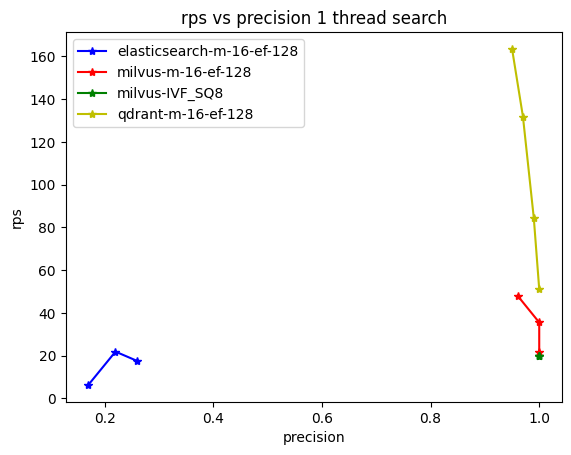

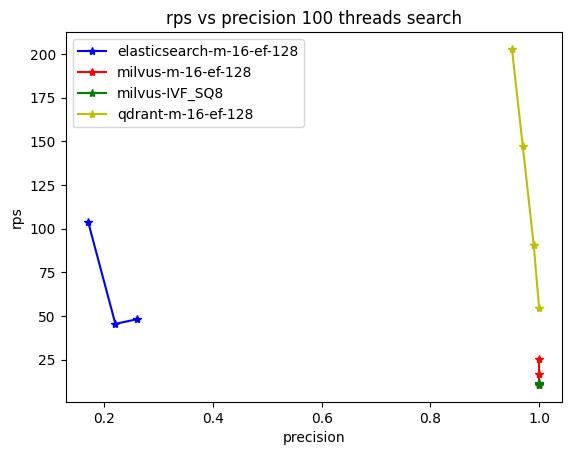

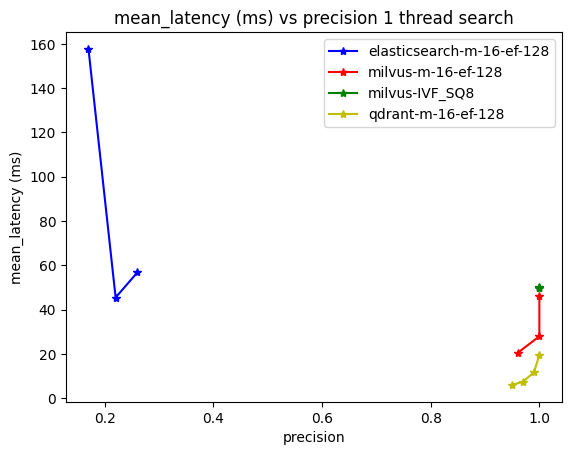

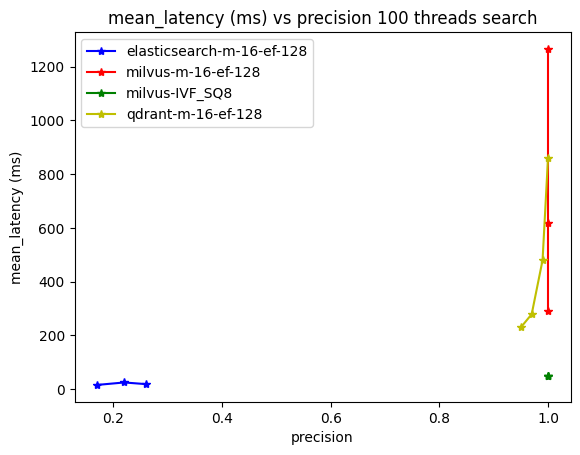

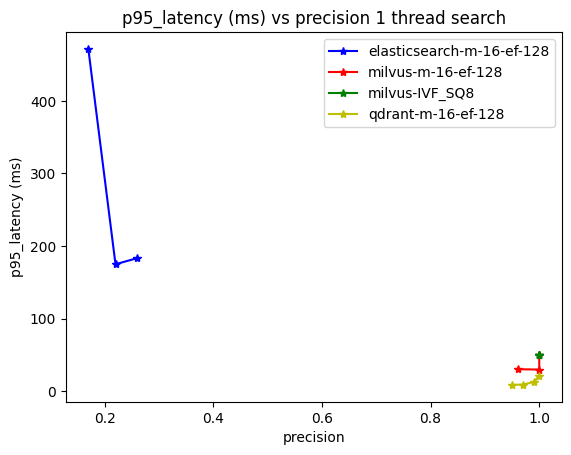

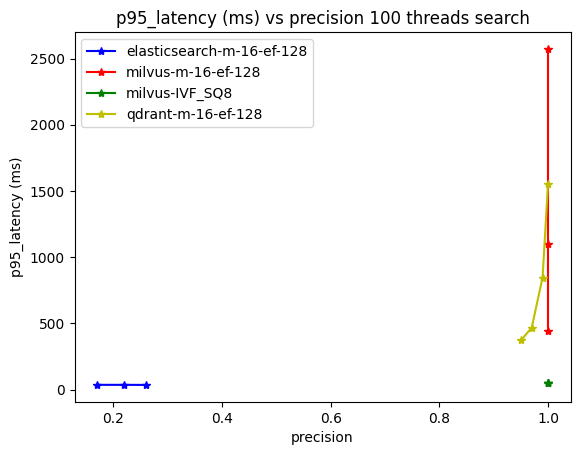

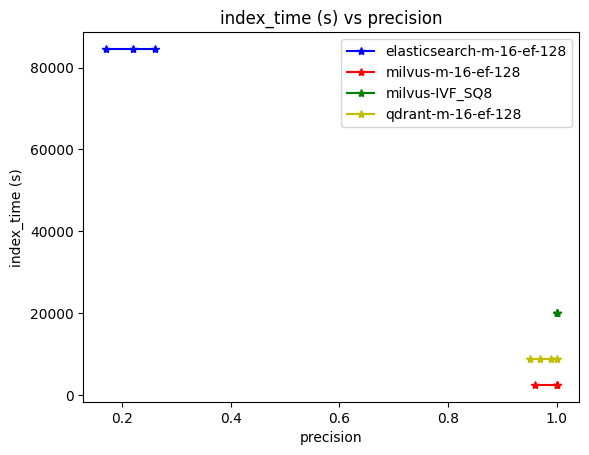

In [30]:
json_results = []

for index, row in joined_df.reset_index().iterrows():
    engine_params = {}
    
    if isinstance(row['params_upload'], dict):
        engine_params.update(row['params_upload'])
    if isinstance(row['params_search'], dict):
        search_params = row['params_search']
        engine_params.update(search_params.get('config', {}))
        engine_params.update(search_params.get('params', {}))
        engine_params.update(search_params.get('search_params', {}))
        engine_params.update(search_params.get('vectorIndexConfig', {}))

    engine_params.pop('experiment')
    engine_params.pop('parallel')

    engine_name = row['engine']

    if engine_name.startswith("qdrant-"):
        engine_name = "qdrant"

    json_object = {
        "engine_name": engine_name,
        "setup_name": f"{row['params_search']['experiment']}",
        "dataset_name": row['dataset'],
        "search_idx": row['search_index'],
        "upload_time": row['results_upload']['upload_time'],
        "total_upload_time": row['results_upload']['total_time'],
        "p95_time": row['results_search']['p95_time'],
        "rps": row['results_search']['rps'],
        "parallel": row['params_search']['parallel'],
        "p99_time": row['results_search']['p99_time'],
        "mean_time": row['results_search']['mean_time'],
        "mean_precisions": row['results_search']['mean_precisions'],
        "engine_params": engine_params,
    }
    json_results.append(json_object)

format = '%Y-%M-%dT%H-%M-%S'
now = datetime.now().replace(tzinfo=timezone.utc).strftime(format)

Path(f"results.json").write_text(json.dumps(json_results, indent=2))
Path(f"results-{now}.json").write_text(json.dumps(json_results, indent=2))

print(json_results[-1], len(json_results))

results_df = pd.DataFrame(json_results).sort_values("p99_time", ascending=True)
# results_df.to_csv('results.csv')
results_df

# plotting the results
results_df=results_df.sort_values("mean_precisions", ascending=True)

x_elastic_precision_thread_1=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['mean_precisions']
y_elastic_rps_thread_1=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['rps']
x_milvus_precision_thread_1=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['mean_precisions']
y_milvus_rps_thread_1=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['rps']
x_milvus_IVF_precision_thread_1=[1.0, 1.0, 1.0]
y_milvus_IVF_rps_thread_1=[19.85, 20.01, 20.06]
x_qdrant_precision_thread_1=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['mean_precisions']
y_qdrant_rps_thread_1=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['rps']
plt.figure(0)
plt.xlabel('precision')
plt.ylabel('rps')
plt.title('rps vs precision 1 thread search')
plt.plot(x_elastic_precision_thread_1,y_elastic_rps_thread_1,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_1,y_milvus_rps_thread_1,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_1,y_milvus_IVF_rps_thread_1,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_1,y_qdrant_rps_thread_1,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.legend()

x_elastic_precision_thread_100=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)]['mean_precisions']
y_elastic_rps_thread_100=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)]['rps']
x_milvus_precision_thread_100=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==100)]['mean_precisions']
y_milvus_rps_thread_100=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==100)]['rps']
x_milvus_IVF_precision_thread_100=[1.0, 1.0, 1.0]
y_milvus_IVF_rps_thread_100=[11.14, 10.75, 11.39]
x_qdrant_precision_thread_100=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==100)]['mean_precisions']
y_qdrant_rps_thread_100=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==100)]['rps']
plt.figure(1)
plt.xlabel('precision')
plt.ylabel('rps')
plt.title('rps vs precision 100 threads search')
plt.plot(x_elastic_precision_thread_100,y_elastic_rps_thread_100,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_100,y_milvus_rps_thread_100,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_100,y_milvus_IVF_rps_thread_100,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_100,y_qdrant_rps_thread_100,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.legend()

y_elastic_latency_mean_thread_1=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['mean_time']
y_elastic_latency_mean_thread_1_millisec = [i * 1000.0 for i in y_elastic_latency_mean_thread_1]
y_milvus_latency_mean_thread_1=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['mean_time']
y_milvus_latency_mean_thread_1_millisec = [i * 1000.0 for i in y_milvus_latency_mean_thread_1]
y_milvus_IVF_latency_mean_thread_1_millisec=[50.19, 49.80, 49.70]
y_qdrant_latency_mean_thread_1=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['mean_time']
y_qdrant_latency_mean_thread_1_millisec = [i * 1000.0 for i in y_qdrant_latency_mean_thread_1]
plt.figure(2)
plt.xlabel('precision')
plt.ylabel('mean_latency (ms)')
plt.title('mean_latency (ms) vs precision 1 thread search')
plt.plot(x_elastic_precision_thread_1,y_elastic_latency_mean_thread_1_millisec,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_1,y_milvus_latency_mean_thread_1_millisec,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_1,y_milvus_IVF_latency_mean_thread_1_millisec,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_1,y_qdrant_latency_mean_thread_1_millisec,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.legend()

y_elastic_latency_mean_thread_100=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)]['mean_time']
y_elastic_latency_mean_thread_100_millisec = [i * 1000.0 for i in y_elastic_latency_mean_thread_100]
y_milvus_latency_mean_thread_100=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==100)]['mean_time']
y_milvus_latency_mean_thread_100_millisec = [i * 1000.0 for i in y_milvus_latency_mean_thread_100]
y_milvus_IVF_latency_mean_thread_100_millisec=[50.19, 49.80, 49.70]
y_qdrant_latency_mean_thread_100=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==100)]['mean_time']
y_qdrant_latency_mean_thread_100_millisec = [i * 1000.0 for i in y_qdrant_latency_mean_thread_100]
plt.figure(3)
plt.xlabel('precision')
plt.ylabel('mean_latency (ms)')
plt.title('mean_latency (ms) vs precision 100 threads search')
plt.plot(x_elastic_precision_thread_100,y_elastic_latency_mean_thread_100_millisec,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_100,y_milvus_latency_mean_thread_100_millisec,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_100,y_milvus_IVF_latency_mean_thread_100_millisec,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_100,y_qdrant_latency_mean_thread_100_millisec,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.legend()

y_elastic_latency_p95_thread_1=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['p95_time']
y_elastic_latency_p95_thread_1_millisec = [i * 1000.0 for i in y_elastic_latency_p95_thread_1]
y_milvus_latency_p95_thread_1=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['p95_time']
y_milvus_latency_p95_thread_1_millisec = [i * 1000.0 for i in y_milvus_latency_p95_thread_1]
y_milvus_IVF_latency_p95_thread_1_millisec=[50.19, 49.80, 49.70]
y_qdrant_latency_p95_thread_1=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['p95_time']
y_qdrant_latency_p95_thread_1_millisec = [i * 1000.0 for i in y_qdrant_latency_p95_thread_1]
plt.figure(4)
plt.xlabel('precision')
plt.ylabel('p95_latency (ms)')
plt.title('p95_latency (ms) vs precision 1 thread search')
plt.plot(x_elastic_precision_thread_1,y_elastic_latency_p95_thread_1_millisec,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_1,y_milvus_latency_p95_thread_1_millisec,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_1,y_milvus_IVF_latency_p95_thread_1_millisec,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_1,y_qdrant_latency_p95_thread_1_millisec,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.legend()

y_elastic_latency_p95_thread_100=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)]['p95_time']
y_elastic_latency_p95_thread_100_millisec = [i * 1000.0 for i in y_elastic_latency_p95_thread_100]
y_milvus_latency_p95_thread_100=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==100)]['p95_time']
y_milvus_latency_p95_thread_100_millisec = [i * 1000.0 for i in y_milvus_latency_p95_thread_100]
y_milvus_IVF_latency_p95_thread_100_millisec=[50.19, 49.80, 49.70]
y_qdrant_latency_p95_thread_100=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==100)]['p95_time']
y_qdrant_latency_p95_thread_100_millisec = [i * 1000.0 for i in y_qdrant_latency_p95_thread_100]
plt.figure(5)
plt.xlabel('precision')
plt.ylabel('p95_latency (ms)')
plt.title('p95_latency (ms) vs precision 100 threads search')
plt.plot(x_elastic_precision_thread_100,y_elastic_latency_p95_thread_100_millisec,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_100,y_milvus_latency_p95_thread_100_millisec,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_100,y_milvus_IVF_latency_p95_thread_100_millisec,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_100,y_qdrant_latency_p95_thread_100_millisec,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.legend()

y_elastic_upload_time_thread_1=list(results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['upload_time'])
y_elastic_total_upload_time_thread_1=list(results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['total_upload_time'])
y_elastic_index_time_thread_1=[y_elastic_total_upload_time_thread_1[i] - y_elastic_upload_time_thread_1[i] for i in range(len(y_elastic_upload_time_thread_1))]
y_milvus_upload_time_thread_1=list(results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['upload_time'])
y_milvus_total_upload_time_thread_1=list(results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['total_upload_time'])
y_milvus_index_time_thread_1=[y_milvus_total_upload_time_thread_1[i] - y_milvus_upload_time_thread_1[i] for i in range(len(y_milvus_upload_time_thread_1))]
y_milvus_IVF_index_time_thread_1=[20029.12, 20029.12, 20029.12]
y_qdrant_upload_time_thread_1=list(results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['upload_time'])
y_qdrant_total_upload_time_thread_1=list(results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['total_upload_time'])
y_qdrant_index_time_thread_1=[y_qdrant_total_upload_time_thread_1[i] - y_qdrant_upload_time_thread_1[i] for i in range(len(y_qdrant_upload_time_thread_1))]
plt.figure(6)
plt.xlabel('precision')
plt.ylabel('index_time (s)')
plt.title('index_time (s) vs precision')
plt.plot(x_elastic_precision_thread_1,y_elastic_index_time_thread_1,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_1,y_milvus_index_time_thread_1,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_1,y_milvus_IVF_index_time_thread_1,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_1,y_qdrant_index_time_thread_1,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.legend()

#results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)].plot.scatter(x = 'mean_precisions', y = 'rps', c = 'red'); 